In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
from PIL import Image

from pytorch3d.renderer import FoVPerspectiveCameras, OpenGLPerspectiveCameras, PerspectiveCameras, SfMPerspectiveCameras, camera_position_from_spherical_angles
from pytorch3d.vis.plotly_vis import plot_scene

from dataset import CustomDataset, Co3dDataset
from eval import evaluate_coordinate_ascent, evaluate_mst
from models import get_model
from utils import unnormalize_image, view_color_coded_images_from_path, view_color_coded_images_from_tensor

In [2]:
def normalize_rotation_matrices(rotations):
    normalized_rotations = []

    for R in rotations:
        # 使用奇异值分解（SVD）分解矩阵 R
        U, S, Vt = np.linalg.svd(R)

        # 修正行列式为+1（确保正向旋转）
        det = np.linalg.det(U @ Vt)
        if det < 0:
            Vt[-1, :] *= -1  # 反转最后一行以修正行列式为+1

        # 重新构建归一化的旋转矩阵并添加到列表中
        normalized_R = U @ Vt
        normalized_rotations.append(normalized_R)

    return np.array(normalized_rotations)


def compute_angular_error_batch(rotation1, rotation2):
    R_rel = np.einsum("Bij,Bjk ->Bik", rotation1.transpose(0, 2, 1), rotation2)
    t = (np.trace(R_rel, axis1=1, axis2=2) - 1) / 2
    theta = np.arccos(np.clip(t, -1, 1))
    return theta * 180 / np.pi

def get_permutations(num_images, eval_time=False):
    if not eval_time:
        permutations = []
        for i in range(1, num_images):
            for j in range(num_images - 1):
                if i > j:
                    permutations.append((j, i))
    else:
        permutations = []
        for i in range(0, num_images):
            for j in range(0, num_images):
                if i != j:
                    permutations.append((j, i))

    return permutations

def get_n_consistent_cameras(R_pred, num_frames):
    R_pred_n = torch.zeros(num_frames, 3, 3)
    R_pred_n[0] = torch.eye(3)
    for k, (i, j) in enumerate(get_permutations(num_frames, eval_time=True)):
        if i == 0:
            R_pred_n[j] = R_pred[k]

    return R_pred_n

def full_scene_scale(R, T):
    def blender2torch3d_objaverse(blw2blc):
        homo = torch.tensor([0,0,0,1]).float()
        R_blc2blw = blw2blc[:3, :3].T.float()
        T_blc2blw = -R_blc2blw @ blw2blc[:3, 3].float()
        blc2blw = torch.cat([R_blc2blw, T_blc2blw[...,None]], axis=-1)
        blc2blw = torch.cat([blc2blw, homo[None,...]], axis=0)
        # * blender to opengl
        blw2glw = torch.tensor([[1,0,0,0], [0,0,1,0], [0,-1,0,0], [0,0,0,1]]).float()
        glw2blc = torch.linalg.inv(blw2glw @ blc2blw)
        # * opengl to pytorch3d
        blc2pyc = torch.tensor([[-1,0,0,0], [0,1,0,0], [0,0,-1,0], [0,0,0,1]]).float()
        glw2pyc = blc2pyc @ glw2blc
        return glw2pyc
    
    R_mtx_ok = torch.zeros_like(R)
    T_vec_ok = torch.zeros_like(T)
    for i in range(len(R)):
        RT_mtx = torch.cat([R[i], T[i][..., None]], dim=-1)
        RT_mtx_ok = blender2torch3d_objaverse(RT_mtx)
        R_mtx_ok[i] = RT_mtx_ok[:3, :3]
        T_vec_ok[i] = RT_mtx_ok[:3, 3]
    # Calculate centroid of cameras in batch
    cameras = FoVPerspectiveCameras(R=R_mtx_ok, T=T_vec_ok)
    cc = cameras.get_camera_center()
    centroid = torch.mean(cc, dim=0)

    # Determine distance from centroid to each camera
    diffs = cc - centroid
    norms = torch.linalg.norm(diffs, dim=1)

    # Scene scale is the distance from the centroid to the furthest camera
    furthest_index = torch.argmax(norms).item()
    scale = norms[furthest_index].item()
    return scale

def compute_optimal_translation_alignment(T_A, T_B, R_B):
    """
    Assuming right-multiplied rotation matrices.

    E.g., for world2cam R and T, a world coordinate is transformed to camera coordinate
    system using X_cam = X_world.T @ R + T = R.T @ X_world + T

    Finds s, t that minimizes || T_A - (s * T_B + R_B.T @ t) ||^2

    Args:
        T_A (torch.Tensor): Target translation (N, 3).
        T_B (torch.Tensor): Initial translation (N, 3).
        R_B (torch.Tensor): Initial rotation (N, 3, 3).

    Returns:
        T_A_hat (torch.Tensor): s * T_B + t @ R_B (N, 3).
        scale s (torch.Tensor): (1,).
        translation t (torch.Tensor): (1, 3).
    """
    n = len(T_A)

    T_A = T_A.unsqueeze(2)
    T_B = T_B.unsqueeze(2)

    A = torch.sum(T_B * T_A)
    B = (T_B.transpose(1, 2) @ R_B.transpose(1, 2)).sum(0) @ (R_B @ T_A).sum(0) / n
    C = torch.sum(T_B * T_B)
    D = (T_B.transpose(1, 2) @ R_B.transpose(1, 2)).sum(0)
    E = (D * D).sum() / n

    s = (A - B.sum()) / (C - E.sum())

    t = (R_B @ (T_A - s * T_B)).sum(0) / n

    T_A_hat = s * T_B + R_B.transpose(1, 2) @ t

    return T_A_hat.squeeze(2), s, t.transpose(1, 0)

def get_error(R_pred, T_pred, R_gt, T_gt, gt_scene_scale):
    T_A_hat, _, _ = compute_optimal_translation_alignment(T_gt, T_pred, R_pred)
    norm = torch.linalg.norm(T_gt - T_A_hat, dim=1) / gt_scene_scale
    norms = np.ndarray.tolist(norm.detach().cpu().numpy())
    norms = np.array(norms)
    return norms, T_A_hat

def rotation_distance(R1, R2, eps=1e-7):
    # http://www.boris-belousov.net/2016/12/01/quat-dist/
    R_diff = R1@R2.transpose(-2, -1)
    trace = R_diff[..., 0, 0] + R_diff[..., 1, 1] + R_diff[..., 2, 2]
    angle = (0.5 * (trace - 1.)).clamp(-1.+eps, 1.-eps).acos_() # numerical stability near -1/+1
    return angle * 180 / np.pi

In [3]:
# Load pretrained weights
model, args = get_model(
    model_dir="/shared/xinyang/threetothreed/relposepp/ckpts_finetune/1026_0506_LR1e-05_N8_RandomNTrue_B36_Pretrainedckpt_back_AMP_TROURS_DDP", # objaverse blender coord
    num_images=3,
    device="cuda"
)

Loading checkpoint ckpt_000005000.pth


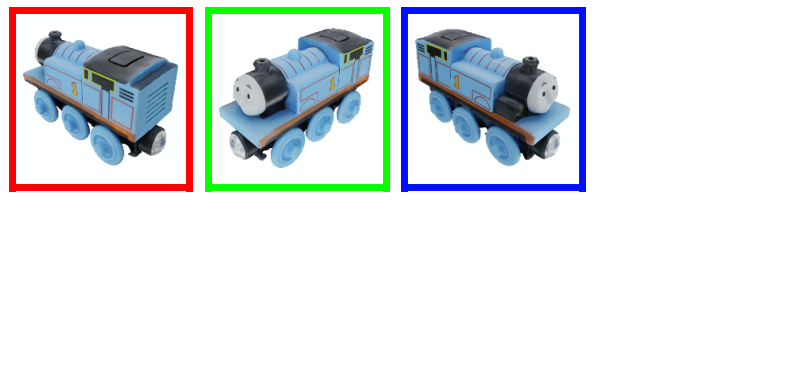

In [4]:
# * GSO
IMAGE_DIR = "/shared/xinyang/threetothreed/dataset/data/train/GSO/Thomas_Friends_Wooden_Railway_Talking_Thomas_z7yi7UFHJRj/images"
MASK_DIR = "/shared/xinyang/threetothreed/dataset/data/train/GSO/Thomas_Friends_Wooden_Railway_Talking_Thomas_z7yi7UFHJRj/masks"
POSE_DIR = "/shared/xinyang/threetothreed/dataset/data/train/GSO/Thomas_Friends_Wooden_Railway_Talking_Thomas_z7yi7UFHJRj/poses"
# # * ABO
# IMAGE_DIR = "/home/xinyang/scratch/zelin_dev/threetothreed/dataset/data/demo/train/ABO_demo/B071J7Q32K/images"
# MASK_DIR = "/home/xinyang/scratch/zelin_dev/threetothreed/dataset/data/demo/train/ABO_demo/B071J7Q32K/masks"
# POSE_DIR = "/home/xinyang/scratch/zelin_dev/threetothreed/dataset/data/demo/train/ABO_demo/B071J7Q32K/poses"
# Visualize initial images
num_frames = view_color_coded_images_from_path(IMAGE_DIR)
# Visualize initial masks
num_frames = view_color_coded_images_from_path(MASK_DIR)
# Load in the wild images and crop parameters
dataset = CustomDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
)
num_frames = dataset.n
batch = dataset.get_data(ids=np.arange(num_frames))
images = batch["image"].to("cuda:0")
crop_params = batch["crop_params"].to("cuda:0")
# Visualize cropped and resized images
view_color_coded_images_from_tensor(images)

In [5]:
# * Quickly initialize a coarse set of poses using MST reasoning
batched_images, batched_crop_params = images.unsqueeze(0), crop_params.unsqueeze(0)
_, hypothesis = evaluate_mst(
    model=model,
    images=batched_images,
    crop_params=batched_crop_params,
)
R_pred = np.stack(hypothesis)

# Regress to optimal translation
with torch.no_grad():
    _, _, T_pred = model(
        images=batched_images,
        crop_params=batched_crop_params,
    )

# Search for optimal rotation via coordinate ascent.
print("Iteratively finetuning the initial MST solution.")
R_pred_rel, hypothesis = evaluate_coordinate_ascent(
    model=model,
    images=batched_images,
    crop_params=batched_crop_params,
)
R_final = torch.from_numpy(np.stack(hypothesis))

Iteratively finetuning the initial MST solution.


In [191]:
R_final_pred = []
T_final_pred = []
for i in range(len(R_final)):
    R_final_i = R_final[i].T
    T_pred_i = T_pred[i].cpu()
    pose_i = torch.cat([R_final_i, T_pred_i[...,None]], dim=-1).cpu().numpy()
    pose_i = torch.from_numpy((pose_i))

    # * +++++++++++++++++++++++++++++
    asd_i = pose_i[:3, :3]
    R_asd = torch.stack([asd_i[:, 0], asd_i[:, 2], -asd_i[:, 1]], dim=0)
    qwe_i = pose_i[:3, 3]
    T_qwe = torch.cat([qwe_i[0:1], qwe_i[1:2], qwe_i[2:3]], dim=-1)
    # * +++++++++++++++++++++++++++++

    R_final_pred.append(R_asd)
    T_final_pred.append(T_qwe)

R_final_pred = torch.stack(R_final_pred)
T_final_pred = torch.stack(T_final_pred)
RT_final_pred = torch.cat(
    [
        R_final_pred,
        T_final_pred[..., None],
    ], 
    dim=-1,
).numpy()

R_final_gt = []
T_final_gt = []

for i in range(len(R_final)):
    pose = np.load(f'{POSE_DIR}/{i:03d}.npy')
    R_final_gt.append(pose[:3, :3])
    T_final_gt.append(torch.tensor(pose[:3, 3]))

R_final_gt = torch.from_numpy(np.stack(R_final_gt))
T_final_gt = torch.stack(T_final_gt)
RT_final_gt = torch.cat(
    [
        R_final_gt,
        T_final_gt[..., None],
    ], 
    dim=-1,
).numpy()


RT_gt = []
RT_ok = []
for i in range(3):
    RT_ok.append(
        np.concatenate([R_final_pred[i], T_final_pred[i][..., None]], axis=-1)
    )
    RT_gt.append(
        np.concatenate([R_final_gt[i], T_final_gt[i][..., None]], axis=-1)
    )

RT_gt = np.stack(RT_gt)
RT_ok = np.stack(RT_ok)
delta_RT_gt = np.zeros_like(RT_gt)
delta_RT_ok = np.zeros_like(RT_ok)
for i in range(3):
    print('++++++GT')
    print(RT_gt[i,:3,:3] * RT_gt[0,:3,:3].T, T_final_pred[i])
    print('======Ours')
    print(RT_ok[i+1,:3,:3] * RT_ok[0,:3,:3].T)

d_theta_1, d_azimuth_1, d_z_1 = get_T(RT_gt[1], RT_gt[0])
d_theta_2, d_azimuth_2, d_z_2 = get_T(RT_gt[2], RT_gt[0])

print('ground truth')
print(d_theta_1/3.14, d_theta_2/3.14)
print(d_azimuth_1/6.28, d_azimuth_2/6.28)
print(d_z_1, d_z_2)

d_theta_1, d_azimuth_1, d_z_1 = get_T(RT_ok[1], RT_ok[0])
d_theta_2, d_azimuth_2, d_z_2 = get_T(RT_ok[2], RT_ok[0])
print('ours')
print(d_theta_1/3.14, d_theta_2/3.14)
print(d_azimuth_1/6.28, d_azimuth_2/6.28)
print(d_z_1, d_z_2)

++++++GT
[[ 1.00000000e+00 -1.87469969e-33 -1.08669380e-40]
 [-1.87469969e-33  2.50000060e-01 -7.49999870e-01]
 [-1.08669380e-40 -7.49999870e-01  2.50000060e-01]] tensor([ 3.0117e-04,  1.1007e-04, -1.5027e+00], dtype=torch.float64)
======Ours
[[-0.70846939  0.          0.        ]
 [-0.          0.         -0.86440414]
 [ 0.          0.61385238  0.        ]]
++++++GT
[[ 7.07106769e-01 -2.16489038e-17  3.42118261e-24]
 [ 3.95044111e-24 -1.15815325e-07 -8.66025432e-01]
 [-1.44904118e-24 -6.12372424e-01 -1.15815325e-07]] tensor([ 3.4315e-04,  8.8990e-05, -1.4995e+00], dtype=torch.float64)
======Ours
[[ 0.69384694  0.          0.        ]
 [ 0.          0.         -0.86395216]
 [ 0.         -0.60027665 -0.        ]]
++++++GT
[[ 7.07106769e-01  2.16489038e-17 -3.42118261e-24]
 [-3.95044111e-24 -1.15815325e-07 -8.66025432e-01]
 [ 1.44904118e-24 -6.12372424e-01 -1.15815325e-07]] tensor([ 3.1843e-04,  4.8019e-05, -1.5009e+00], dtype=torch.float64)
======Ours


IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:

# R_final_pred = normalize_rotation_matrices(R_final_pred)
# R_final_gt = normalize_rotation_matrices(R_final_gt)

# RT_gt = []
# RT_ok = []
# for i in range(3):
#     RT_ok.append(
#         np.concatenate([R_final_pred[i], T_final_pred[i][..., None]], axis=-1)
#     )
#     RT_gt.append(
#         np.concatenate([R_final_gt[i], T_final_gt[i][..., None]], axis=-1)
#     )

# RT_gt = np.stack(RT_gt)
# RT_ok = np.stack(RT_ok)
# for i in range(2):
#     print('++++++GT')
#     print(RT_gt[i+1,:3,:3] * RT_gt[i,:3,:3].T)
#     print('======Ours')
#     print(RT_ok[i+1,:3,:3] * RT_ok[i,:3,:3].T)

# d_theta_1, d_azimuth_1, d_z_1 = get_T(RT_gt[1], RT_gt[0])
# d_theta_2, d_azimuth_2, d_z_2 = get_T(RT_gt[2], RT_gt[0])

# print('ground truth')
# print(d_theta_1/3.14, d_theta_2/3.14)
# print(d_azimuth_1/6.28, d_azimuth_2/6.28)
# print(d_z_1, d_z_2)

# d_theta_1, d_azimuth_1, d_z_1 = get_T(RT_ok[1], RT_ok[0])
# d_theta_2, d_azimuth_2, d_z_2 = get_T(RT_ok[2], RT_ok[0])
# print('ours')
# print(d_theta_1/3.14, d_theta_2/3.14)
# print(d_azimuth_1/6.28, d_azimuth_2/6.28)
# print(d_z_1, d_z_2)

In [111]:
# R_final_pred = normalize_rotation_matrices(R_final_pred)
# R_final_gt = normalize_rotation_matrices(R_final_gt)

# permutations = get_permutations(num_frames, eval_time=True)
# n_p = len(permutations)
# relative_rotation = np.zeros((n_p, 3, 3))
# for k, t in enumerate(permutations):
#     i, j = t
#     relative_rotation[k] = R_final_gt[i].T @ R_final_gt[j]
# R_gt_rel = relative_rotation

# permutations = get_permutations(num_frames, eval_time=True)
# n_p = len(permutations)
# relative_rotation = np.zeros((n_p, 3, 3))
# for k, t in enumerate(permutations):
#     i, j = t
#     relative_rotation[k] = R_final_pred[i].T @ R_final_pred[j]
# R_final_pred_rel = relative_rotation

# error_R = compute_angular_error_batch(R_final_pred_rel, R_gt_rel)

# R_pred_n = get_n_consistent_cameras(torch.from_numpy(R_pred_rel), num_frames)
# gt_scene_scale = full_scene_scale(torch.from_numpy(R_final_gt), T_final_gt)
# error_t, A_hat = get_error(R_pred_n.float(), T_pred.cpu().float(), R_final_gt, T_final_gt.float(), gt_scene_scale)

# print(f'rotation error: {error_R.mean():.5f} translation error: {error_t.mean():.3f}')

In [192]:
# R_final_pred = normalize_rotation_matrices(R_final_pred)
# R_final_gt = normalize_rotation_matrices(R_final_gt)
# print(R_final_pred[0], T_final_pred[0])
# print(R_final_gt[0], T_final_gt[0])


In [10]:
def cartesian_to_spherical(xyz):
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    xy = xyz[:,0]**2 + xyz[:,1]**2
    z = np.sqrt(xy + xyz[:,2]**2)
    theta = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    #ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    azimuth = np.arctan2(xyz[:,1], xyz[:,0])
    return np.array([theta, azimuth, z])

def get_T(target_RT, cond_RT):
    R, T = target_RT[:3, :3], target_RT[:, -1]
    T_target = -R.T @ T

    R, T = cond_RT[:3, :3], cond_RT[:, -1]
    T_cond = -R.T @ T

    theta_cond, azimuth_cond, z_cond = cartesian_to_spherical(T_cond[None, :])
    theta_target, azimuth_target, z_target = cartesian_to_spherical(T_target[None, :])
    
    d_theta = theta_target - theta_cond
    d_azimuth = (azimuth_target - azimuth_cond) % (2 * np.pi)
    d_z = z_target - z_cond

    return d_theta, d_azimuth, d_z

In [11]:
d_theta_1, d_azimuth_1, d_z_1 = get_T(RT_gt[1], RT_gt[0])
d_theta_2, d_azimuth_2, d_z_2 = get_T(RT_gt[2], RT_gt[0])

print('ground truth')
print(d_theta_1/3.14, d_theta_2/3.14)
print(d_azimuth_1/6.28, d_azimuth_2/6.28)
print(d_z_1, d_z_2)

d_theta_1, d_azimuth_1, d_z_1 = get_T(RT_ok[1], RT_ok[0])
d_theta_2, d_azimuth_2, d_z_2 = get_T(RT_ok[2], RT_ok[0])
print('ours')
# d_theta_1 = d_theta_1 % np.pi
print(d_theta_1/3.14, d_theta_2/3.14)
print(d_azimuth_1/6.28, d_azimuth_2/6.28)
print(d_z_1, d_z_2)

NameError: name 'RT_gt' is not defined